# Plant Pest and Disease Detection

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
DATASET_DIR = "/kaggle/input/crop-pest-and-disease-detection"

In [7]:
# Remove the .DS_Store file from the Dataset directory and al the subdirectories
path = DATASET_DIR
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        if name == ".DS_Store":
            os.remove(os.path.join(root, name))

In [8]:
# store all the files names in the Data directory
class_names = os.listdir(DATASET_DIR)
class_names

['Tomato verticulium wilt',
 'Cassava green mite',
 'Cassava mosaic',
 'Cashew red rust',
 'Cashew gumosis',
 'Tomato healthy',
 'Cassava brown spot',
 'Cassava bacterial blight',
 'Maize leaf beetle',
 'Cassava healthy',
 'Maize leaf spot',
 'Maize healthy',
 'Tomato leaf blight',
 'Cashew healthy',
 'Cashew leaf miner',
 'Maize streak virus',
 'Tomato septoria leaf spot',
 'Maize leaf blight',
 'Maize grasshoper',
 'Cashew anthracnose',
 'Tomato leaf curl',
 'Maize fall armyworm']

In [9]:
EPOCHS = 10
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
MAX_IMAGES_PER_CATEGORY = 5000
CLASS_NAMES = [
    "Tomato verticulium wilt",
    "Cassava green mite",
    "Cassava mosaic",
    "Cashew red rust",
    "Cashew gumosis",
    "Tomato healthy",
    "Cassava brown spot",
    "Cassava bacterial blight",
    "Maize leaf beetle",
    "Cassava healthy",
    "Maize leaf spot",
    "Maize healthy",
    "Tomato leaf blight",
    "Cashew healthy",
    "Cashew leaf miner",
    "Maize streak virus",
    "Tomato septoria leaf spot",
    "Maize leaf blight",
    "Maize grasshoper",
    "Cashew anthracnose",
    "Tomato leaf curl",
    "Maize fall armyworm",
]

### Helper Functions for Processing Data


In [10]:
def get_disease_category_by_path(file_path):
    return file_path.split("/")[4]


def get_plant_category_by_path(file_path):
    disease_category = get_disease_category_by_path(file_path)
    return disease_category.split(" ")[0]

In [11]:
def process_images(images):
    image_list = []

    for filename in images:
        img = tf.io.read_file(filename)
        img = tf.io.decode_jpeg(img)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)

        image_list.append(img)

    return image_list

In [12]:
def clean_image_dataframe(df):
    for image in df["filename"]:
        try:
            img = tf.io.read_file(image)
            img = tf.io.decode_jpeg(img)
        except:
            index = df[(df.filename == image)].index
            df = df.drop(index)
    return df

In [13]:
def encode_label(label):
    if label == "Tomato verticulium wilt":
        return 0
    elif label == "Cassava green mite":
        return 1
    elif label == "Cassava mosaic":
        return 2
    elif label == "Cashew red rust":
        return 3
    elif label == "Cashew gumosis":
        return 4
    elif label == "Tomato healthy":
        return 5
    elif label == "Cassava brown spot":
        return 6
    elif label == "Cassava bacterial blight":
        return 7
    elif label == "Maize leaf beetle":
        return 8
    elif label == "Cassava healthy":
        return 9
    elif label == "Maize leaf spot":
        return 10
    elif label == "Maize healthy":
        return 11
    elif label == "Tomato leaf blight":
        return 12
    elif label == "Cashew healthy":
        return 13
    elif label == "Cashew leaf miner":
        return 14
    elif label == "Maize streak virus":
        return 15
    elif label == "Tomato septoria leaf spot":
        return 16
    elif label == "Maize leaf blight":
        return 17
    elif label == "Maize grasshoper":
        return 18
    elif label == "Cashew anthracnose":
        return 19
    elif label == "Tomato leaf curl":
        return 20
    elif label == "Maize fall armyworm":
        return 21
    else:
        return -1

### Perform EDA (Exploratory Data Analysis)


In [14]:
filenames = []
plant_category = []
disease_category = []

# sort the categories and filenames into lists
for root, dirs, files in os.walk(DATASET_DIR):
    for filename in files:
        fn = str(root + "/" + filename)
        filenames.append(fn)

        pc = get_plant_category_by_path(fn)
        plant_category.append(pc)

        dc = get_disease_category_by_path(fn)
        disease_category.append(dc)

In [15]:
# create a Pandas dataframe using the lists
data = {
    "filename": filenames,
    "plant category": plant_category,
    "disease category": disease_category,
}
df = pd.DataFrame(data)
df = df.sample(frac=1)  # shuffle the dataframe

print(df.head(10))

                                                filename plant category  \
12450  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
17135  /kaggle/input/crop-pest-and-disease-detection/...         Cashew   
12400  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
6212   /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
6771   /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
10076  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
21859  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
22818  /kaggle/input/crop-pest-and-disease-detection/...         Cashew   
18681  /kaggle/input/crop-pest-and-disease-detection/...         Tomato   
23131  /kaggle/input/crop-pest-and-disease-detection/...         Cashew   

                disease category  
12450            Maize leaf spot  
17135          Cashew leaf miner  
12400            Maize leaf spot  
6212          Cassava brown spot  

In [16]:
# remove invalid images from the dataframe
df = clean_image_dataframe(df)
print(f"Length of DF: {len(df['filename'])}")

Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x7a
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x7a
Corrupt JPEG data: 31005 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x5a
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x45
Unsupported marker type 0xf0
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x1d
Invalid JPEG file structure: SOS before SOF
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x75
Corrupt JPEG data: 29224 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: 26519 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: 457 extraneous bytes before marker 0x5a
Unsupported marker type 0x5a
Corrupt JPEG data: 37 extraneous bytes before marker 0xdb
Bogus marker length
Corrupt 

Length of DF: 25124


In [18]:
category_sizes_plant = df.groupby("plant category").size()
print(category_sizes_plant)

plant category
Cashew     6549
Cassava    7508
Maize      5288
Tomato     5779
dtype: int64


In [19]:
category_sizes_disease = df.groupby("disease category").size()
print(category_sizes_disease)

disease category
Cashew anthracnose           1729
Cashew gumosis                392
Cashew healthy               1368
Cashew leaf miner            1378
Cashew red rust              1682
Cassava bacterial blight     2614
Cassava brown spot           1481
Cassava green mite           1015
Cassava healthy              1193
Cassava mosaic               1205
Maize fall armyworm           285
Maize grasshoper              673
Maize healthy                 204
Maize leaf beetle             932
Maize leaf blight             990
Maize leaf spot              1239
Maize streak virus            965
Tomato healthy                466
Tomato leaf blight           1288
Tomato leaf curl              510
Tomato septoria leaf spot    2743
Tomato verticulium wilt       772
dtype: int64


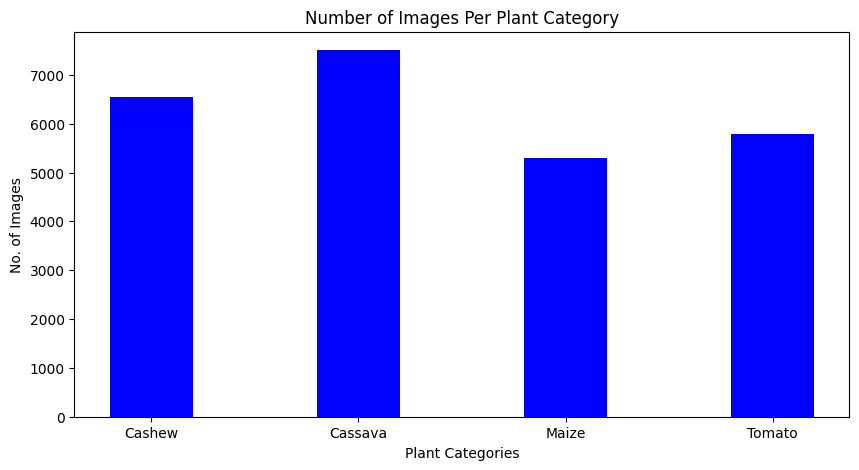

In [20]:
categories = df["plant category"].sort_values().unique()

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(categories, category_sizes_plant, color="blue", width=0.4)

plt.xlabel("Plant Categories")
plt.ylabel("No. of Images")
plt.title("Number of Images Per Plant Category")
plt.show()

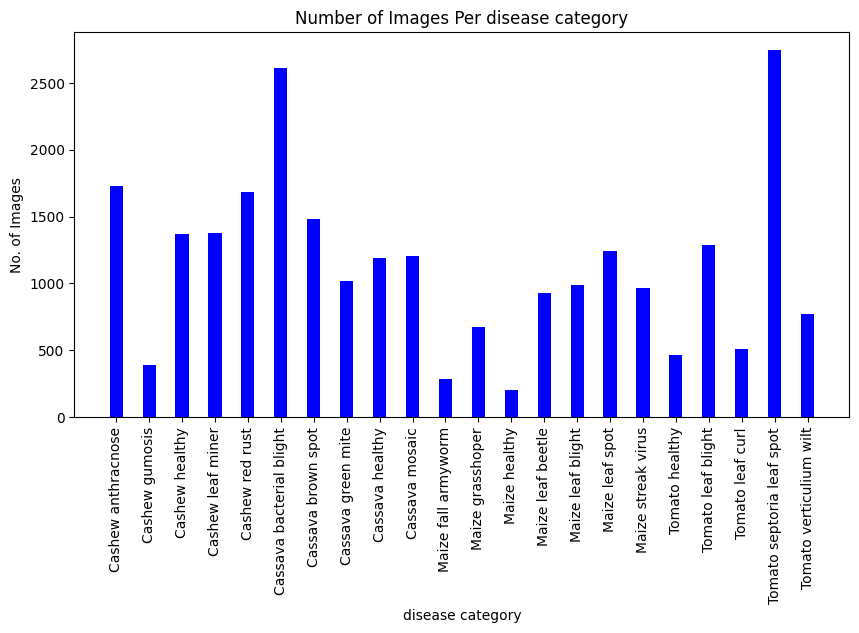

In [31]:
categories = df["disease category"].sort_values().unique()

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(categories, category_sizes_disease, color="blue", width=0.4)

plt.xlabel("disease category")
plt.ylabel("No. of Images")
plt.title("Number of Images Per disease category")
plt.xticks(rotation=90)
plt.show()

### Create a Balanced Training Dataset and Validation Dataset


We have an unbalanced set of images. There are nearly 20% more Cassava images than Maize images. Let's use only 5000 images from each category to create the training and validation datasets.
We can use the remaining images to create a test dataset for evaluating the model after training.


In [32]:
# truncate the number of images in each category so each have an equal amount
cashew_files = [
    df["filename"].values[index]
    for index, x in enumerate(df["plant category"].values)
    if "Cashew" == x
][0:MAX_IMAGES_PER_CATEGORY]
cassava_files = [
    df["filename"].values[index]
    for index, x in enumerate(df["plant category"].values)
    if "Cassava" == x
][0:MAX_IMAGES_PER_CATEGORY]
maize_files = [
    df["filename"].values[index]
    for index, x in enumerate(df["plant category"].values)
    if "Maize" == x
][0:MAX_IMAGES_PER_CATEGORY]
tomato_files = [
    df["filename"].values[index]
    for index, x in enumerate(df["plant category"].values)
    if "Tomato" == x
][0:MAX_IMAGES_PER_CATEGORY]

In [34]:
cashew_files[:5]

['/kaggle/input/crop-pest-and-disease-detection/Cashew leaf miner/leaf miner868_.jpg',
 '/kaggle/input/crop-pest-and-disease-detection/Cashew anthracnose/anthracnose747_.jpg',
 '/kaggle/input/crop-pest-and-disease-detection/Cashew anthracnose/anthracnose1135_.jpg',
 '/kaggle/input/crop-pest-and-disease-detection/Cashew leaf miner/leaf miner955_.jpg',
 '/kaggle/input/crop-pest-and-disease-detection/Cashew anthracnose/anthracnose941_.jpg']

In [45]:
dataset = []

# get the name of the disease category for each image
for files in [cashew_files, cassava_files, maize_files, tomato_files]:
    for file in files:
        data_subset = []
        data_subset.append(file)
        data_subset.append(encode_label(get_disease_category_by_path(file)))

        dataset.append(data_subset)

unbalanced_dataset_size = len(df["filename"].unique())
balanced_dataset_size = len(dataset)
loss = round((1 - (balanced_dataset_size / unbalanced_dataset_size)) * 100, 2)

print(f"Size of Unbalanced Dataset: {unbalanced_dataset_size}")
print(f"Size of Balanced Dataset: {balanced_dataset_size}")

Size of Unbalanced Dataset: 25124
Size of Balanced Dataset: 20000


In [46]:
# def create_dataset(filenames, label):
#   for filename in filenames:
#     data_subset = []
#     data_subset.append(filename)
#     data_subset.append(encode_label(label))

#     dataset.append(data_subset)

# create_dataset(cashew_files, 'Cashew')
# create_dataset(cassava_files, 'Cassava')
# create_dataset(maize_files, 'Maize')
# create_dataset(tomato_files, 'Tomato')

# unbalanced_dataset_size = len(df['filename'].unique())
# balanced_dataset_size = len(dataset)
# loss = round((1 - (balanced_dataset_size / unbalanced_dataset_size)) * 100, 2)

# print(f"Size of Unbalanced Dataset: {unbalanced_dataset_size}")
# print(f"Size of Balanced Dataset: {balanced_dataset_size}")

In [47]:
dataset_df = pd.DataFrame(dataset, columns=["filename", "label"])
dataset_df.head()

filename  label
0  /kaggle/input/crop-pest-and-disease-detection/...     14
1  /kaggle/input/crop-pest-and-disease-detection/...     19
2  /kaggle/input/crop-pest-and-disease-detection/...     19
3  /kaggle/input/crop-pest-and-disease-detection/...     14
4  /kaggle/input/crop-pest-and-disease-detection/...     19

In [48]:
X = dataset_df["filename"]
y = dataset_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [49]:
X_train = process_images(X_train)
X_test = process_images(X_test)

In [50]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((X_train, y_train))
validation_ds = tf.data.Dataset.zip((X_test, y_test))

In [51]:
train_ds = (
    train_ds.cache()
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)
validation_ds = validation_ds.batch(BATCH_SIZE)

### Visualize a Subset of the Training Dataset


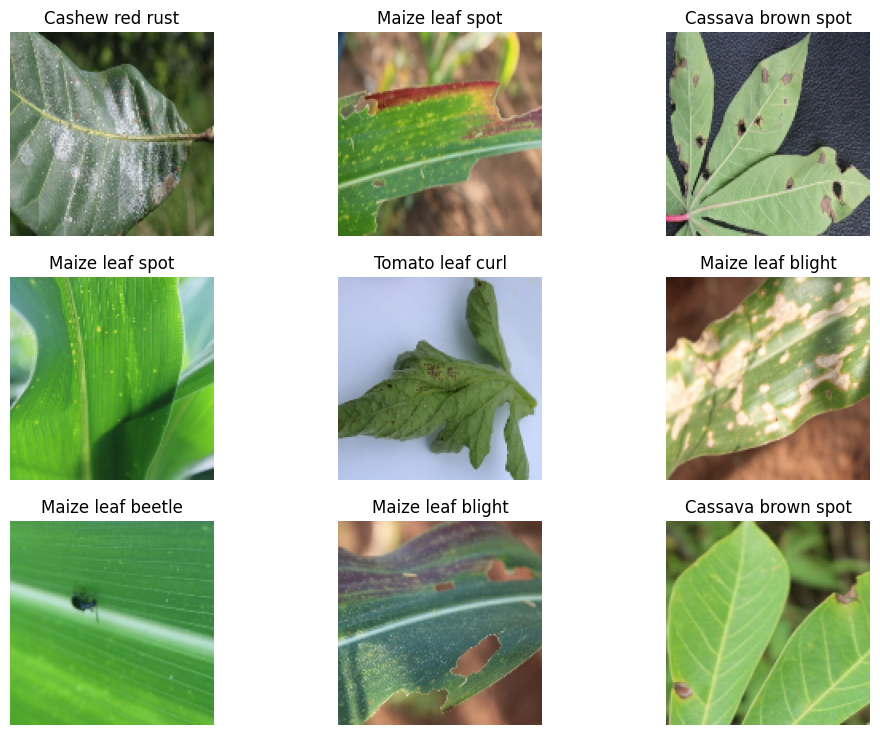

In [52]:
plt.figure(figsize=(12, 9))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[label[i]])
        plt.axis("off")

#### Generate a Test Dataset from Remaining Images After Truncation


In [53]:
# Take the remaining images and create a test set that won't be seen during training
STARTING_POINT = MAX_IMAGES_PER_CATEGORY + 1
cashew_files = [
    df["filename"].values[index]
    for index, x in enumerate(df["plant category"].values)
    if "Cashew" == x
][STARTING_POINT:]
cassava_files = [
    df["filename"].values[index]
    for index, x in enumerate(df["plant category"].values)
    if "Cassava" == x
][STARTING_POINT:]
maize_files = [
    df["filename"].values[index]
    for index, x in enumerate(df["plant category"].values)
    if "Maize" == x
][STARTING_POINT:]
tomato_files = [
    df["filename"].values[index]
    for index, x in enumerate(df["plant category"].values)
    if "Tomato" == x
][STARTING_POINT:]

In [54]:
test_dataset = []

# get the name of the disease category for each image
for files in [cashew_files, cassava_files, maize_files, tomato_files]:
    for file in files:
        data_subset = []
        data_subset.append(file)
        data_subset.append(encode_label(get_disease_category_by_path(file)))

        test_dataset.append(data_subset)

test_dataset_size = len(test_dataset)
print(f"Size of Test Dataset: {test_dataset_size}")

test_dataset_df = pd.DataFrame(test_dataset, columns=["filename", "label"])
print(test_dataset_df.head())

test_images = process_images(test_dataset_df["filename"])
test_labels = test_dataset_df["label"]

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH_SIZE)

Size of Test Dataset: 5120
                                            filename  label
0  /kaggle/input/crop-pest-and-disease-detection/...     19
1  /kaggle/input/crop-pest-and-disease-detection/...     14
2  /kaggle/input/crop-pest-and-disease-detection/...     13
3  /kaggle/input/crop-pest-and-disease-detection/...     19
4  /kaggle/input/crop-pest-and-disease-detection/...     13


In [55]:
base_model = tf.keras.applications.VGG16(
    include_top=False, input_shape=INPUT_SHAPE, weights="imagenet"
)
base_model.trainable = False

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [56]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(class_names)),
    ]
)

In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [61]:
history = model.fit(train_ds, epochs=30, validation_data=validation_ds)

Epoch 1/30
469/469 [==============================] - 16s 34ms/step - loss: 6.6251 - accuracy: 0.4031 - val_loss: 7.1512 - val_accuracy: 0.5146
Epoch 2/30
469/469 [==============================] - 16s 34ms/step - loss: 6.4255 - accuracy: 0.4111 - val_loss: 6.7386 - val_accuracy: 0.5230
Epoch 3/30
469/469 [==============================] - 16s 34ms/step - loss: 5.7675 - accuracy: 0.4221 - val_loss: 6.4658 - val_accuracy: 0.5236
Epoch 4/30
469/469 [==============================] - 16s 33ms/step - loss: 5.5082 - accuracy: 0.4258 - val_loss: 6.2006 - val_accuracy: 0.5350
Epoch 5/30
469/469 [==============================] - 16s 34ms/step - loss: 5.1567 - accuracy: 0.4416 - val_loss: 5.8028 - val_accuracy: 0.5430
Epoch 6/30
469/469 [==============================] - 16s 33ms/step - loss: 5.1893 - accuracy: 0.4444 - val_loss: 5.6205 - val_accuracy: 0.5452
Epoch 7/30
469/469 [==============================] - 16s 34ms/step - loss: 4.7357 - accuracy: 0.4562 - val_loss: 5.5009 - val_accuracy:

### **Classification Report**


In [62]:
# Assuming 'test_ds' is your test dataset
test_accuracy_custom = model.evaluate(test_ds, return_dict=True)["accuracy"]
print("Test Accuracy:", test_accuracy_custom)

160/160 [==============================] - 4s 24ms/step - loss: 1.6211 - accuracy: 0.6186
Test Accuracy: 0.6185547113418579


In [63]:
# Assuming 'test_ds' is your test dataset
test_loss_custom = model.evaluate(test_ds, return_dict=True)["loss"]
print("Test Loss:", test_loss_custom)

160/160 [==============================] - 4s 24ms/step - loss: 1.6211 - accuracy: 0.6186
Test Loss: 1.621111512184143


Text(0.5, 0, 'Epoch')

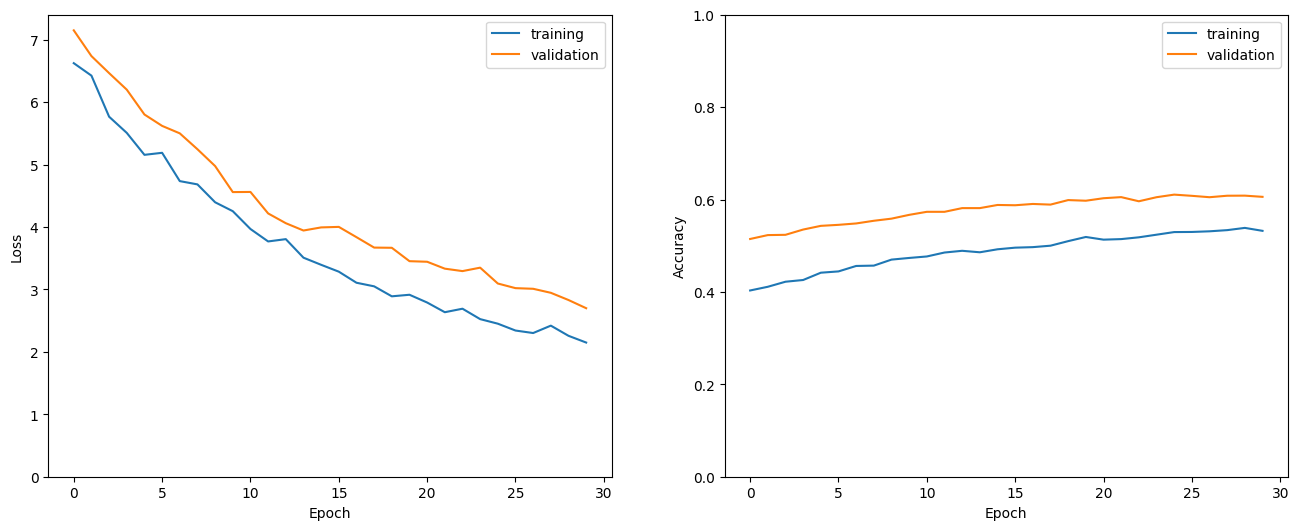

In [64]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["training", "validation"])
plt.ylim([0, max(plt.ylim())])
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics["accuracy"], metrics["val_accuracy"])
plt.legend(["training", "validation"])
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

In [65]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

160/160 [==============================] - 4s 23ms/step


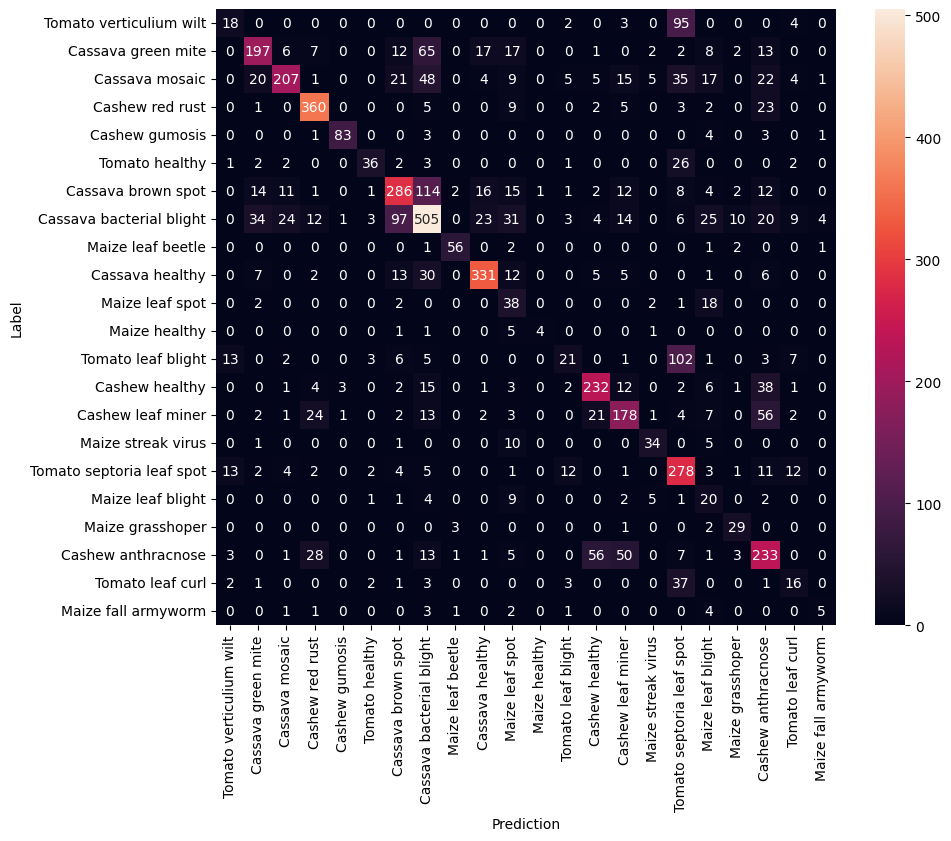

In [66]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

In [70]:
# Calculate precision, recall, and F1-score
precision = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
recall = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")
    print()

Class: Tomato verticulium wilt
  Precision: 0.3600
  Recall: 0.1475
  F1-score: 0.2093

Class: Cassava green mite
  Precision: 0.6961
  Recall: 0.5645
  F1-score: 0.6234

Class: Cassava mosaic
  Precision: 0.7962
  Recall: 0.4940
  F1-score: 0.6097

Class: Cashew red rust
  Precision: 0.8126
  Recall: 0.8780
  F1-score: 0.8441

Class: Cashew gumosis
  Precision: 0.9432
  Recall: 0.8737
  F1-score: 0.9071

Class: Tomato healthy
  Precision: 0.7500
  Recall: 0.4800
  F1-score: 0.5854

Class: Cassava brown spot
  Precision: 0.6327
  Recall: 0.5697
  F1-score: 0.5996

Class: Cassava bacterial blight
  Precision: 0.6041
  Recall: 0.6121
  F1-score: 0.6081

Class: Maize leaf beetle
  Precision: 0.8889
  Recall: 0.8889
  F1-score: 0.8889

Class: Cassava healthy
  Precision: 0.8380
  Recall: 0.8034
  F1-score: 0.8203

Class: Maize leaf spot
  Precision: 0.2222
  Recall: 0.6032
  F1-score: 0.3248

Class: Maize healthy
  Precision: 0.8000
  Recall: 0.3333
  F1-score: 0.4706

Class: Tomato leaf b

In [71]:
# Calculate overall metrics
macro_avg_precision = np.mean(precision)
macro_avg_recall = np.mean(recall)
macro_avg_f1_score = np.mean(f1_score)

print("Overall Metrics:")
print(f"  Macro-average Precision: {macro_avg_precision:.4f}")
print(f"  Macro-average Recall: {macro_avg_recall:.4f}")
print(f"  Macro-average F1-score: {macro_avg_f1_score:.4f}")

Overall Metrics:
  Macro-average Precision: 0.5979
  Macro-average Recall: 0.5676
  Macro-average F1-score: 0.5585


In [67]:
print(y_pred)

[ 3 14 13 ... 16 16 16]


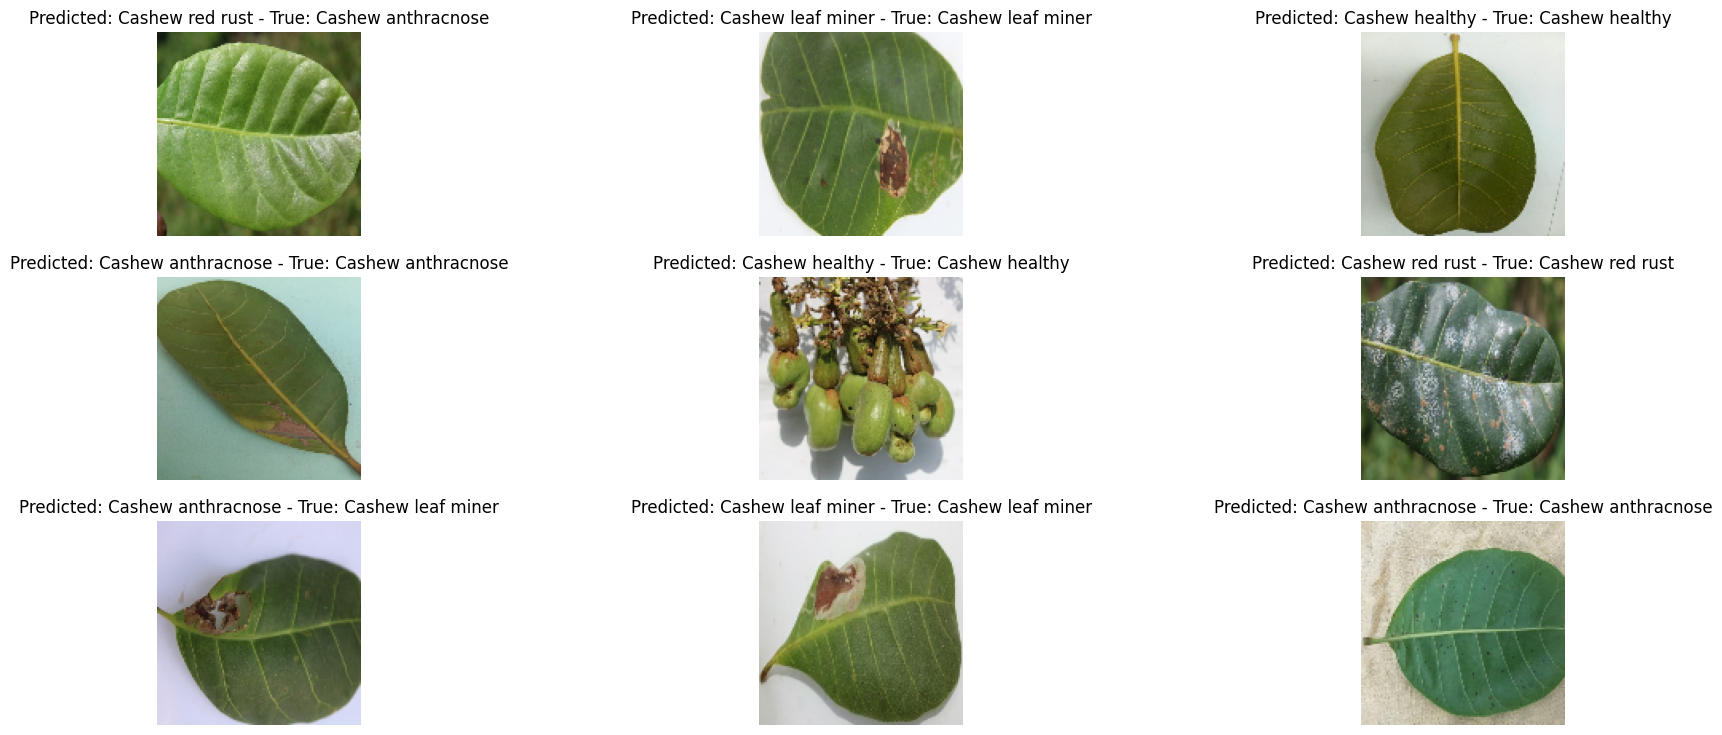

In [69]:
plt.figure(figsize=(22, 9))
for image, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(
            f"Predicted: {CLASS_NAMES[y_pred[i]]} - True: {CLASS_NAMES[y_true[i]]}"
        )
        plt.axis("off")

In [73]:
model.save("/kaggle/working/custom_cnn.h5")

# Resnet101


In [74]:
LEARNING_RATE = 0.0001  # Decrease learning rate
EPOCHS = 10  # Increase number of epochs

In [75]:
# Define a more complex model, possibly with fine-tuning
base_model = tf.keras.applications.ResNet101(
    include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)

171446536/171446536 [==============================] - 2s 0us/step


In [76]:
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Fine-tune the top layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [77]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

In [78]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [79]:
# Train the model with increased epochs and data augmentation
history = model.fit(
    train_ds, epochs=15, validation_data=validation_ds, callbacks=[early_stopping]
)

Epoch 1/15
469/469 [==============================] - 141s 144ms/step - loss: 1.1516 - accuracy: 0.6434 - val_loss: 0.5949 - val_accuracy: 0.7978
Epoch 2/15
469/469 [==============================] - 63s 135ms/step - loss: 0.5248 - accuracy: 0.8221 - val_loss: 0.5542 - val_accuracy: 0.8128
Epoch 3/15
469/469 [==============================] - 64s 136ms/step - loss: 0.3555 - accuracy: 0.8784 - val_loss: 0.5385 - val_accuracy: 0.8298
Epoch 4/15
469/469 [==============================] - 64s 136ms/step - loss: 0.2504 - accuracy: 0.9155 - val_loss: 0.5881 - val_accuracy: 0.8366
Epoch 5/15
469/469 [==============================] - 63s 135ms/step - loss: 0.1996 - accuracy: 0.9327 - val_loss: 0.5956 - val_accuracy: 0.8440
Epoch 6/15
469/469 [==============================] - 63s 134ms/step - loss: 0.1634 - accuracy: 0.9439 - val_loss: 0.6406 - val_accuracy: 0.8346
Epoch 7/15
469/469 [==============================] - 63s 135ms/step - loss: 0.1374 - accuracy: 0.9548 - val_loss: 0.6209 - val_a

In [80]:
# Assuming 'test_ds' is your test dataset
test_accuracy_resnet = model.evaluate(test_ds, return_dict=True)["accuracy"]
print("Test Accuracy:", test_accuracy_resnet)

160/160 [==============================] - 6s 41ms/step - loss: 0.4779 - accuracy: 0.8771
Test Accuracy: 0.877148449420929


In [81]:
# Assuming 'test_ds' is your test dataset
test_loss_resnet = model.evaluate(test_ds, return_dict=True)["loss"]
print("Test Loss:", test_loss_resnet)

160/160 [==============================] - 6s 40ms/step - loss: 0.4779 - accuracy: 0.8771
Test Loss: 0.47785311937332153


Text(0.5, 0, 'Epoch')

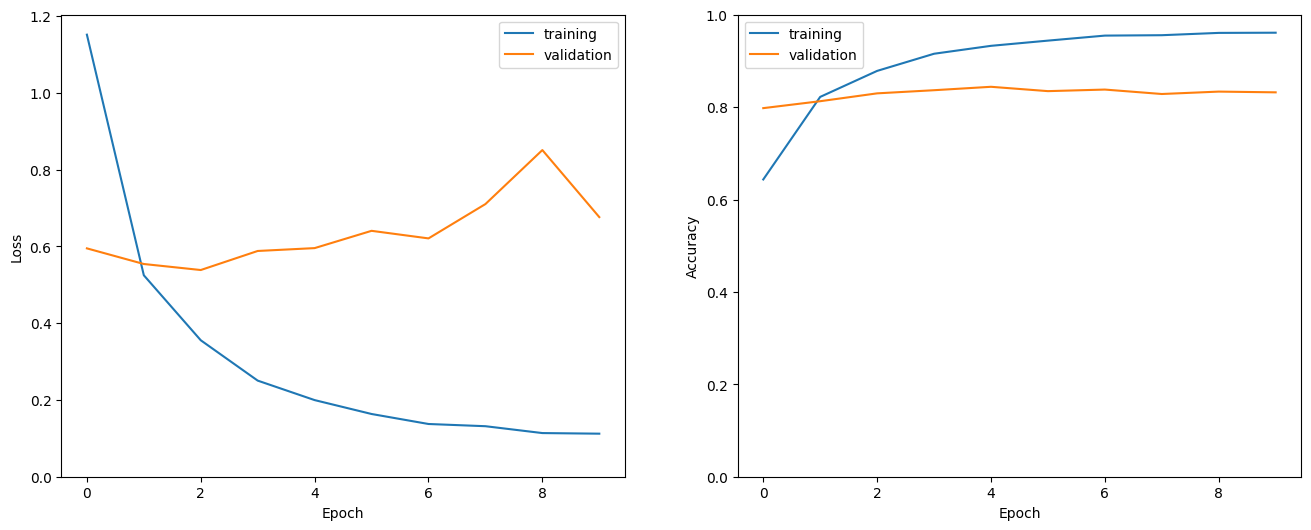

In [82]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["training", "validation"])
plt.ylim([0, max(plt.ylim())])
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics["accuracy"], metrics["val_accuracy"])
plt.legend(["training", "validation"])
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

In [83]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

160/160 [==============================] - 8s 37ms/step


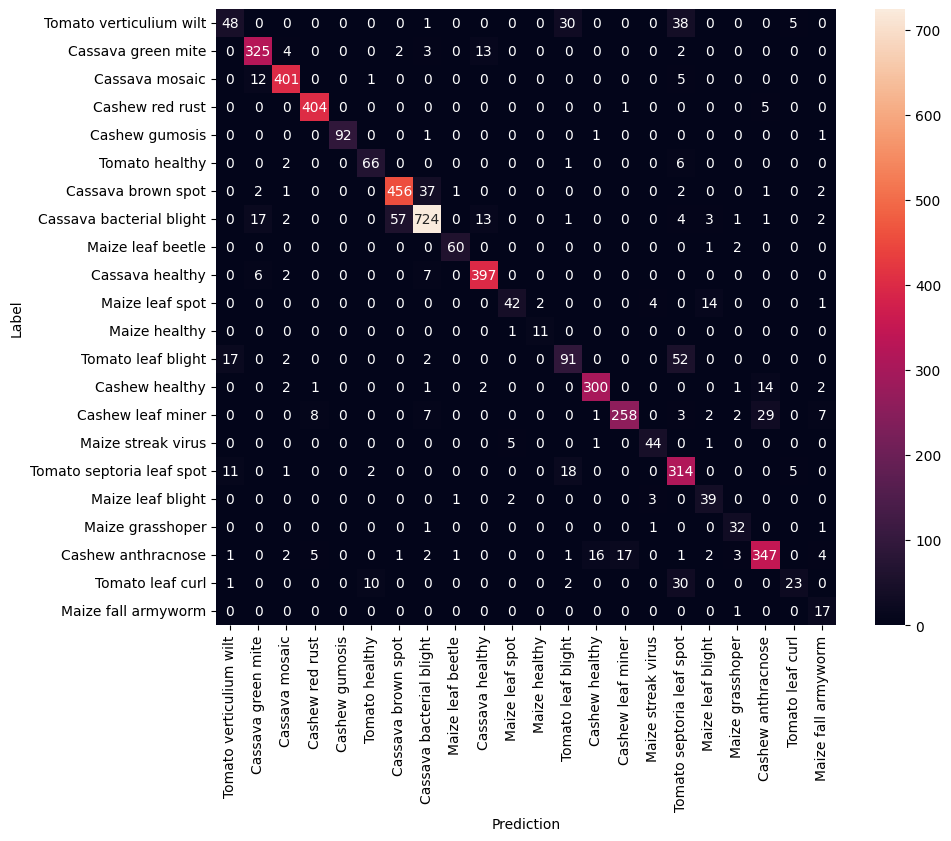

In [84]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

In [85]:
# Calculate precision, recall, and F1-score
precision = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
recall = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")
    print()

Class: Tomato verticulium wilt
  Precision: 0.6154
  Recall: 0.3934
  F1-score: 0.4800

Class: Cassava green mite
  Precision: 0.8978
  Recall: 0.9312
  F1-score: 0.9142

Class: Cassava mosaic
  Precision: 0.9570
  Recall: 0.9570
  F1-score: 0.9570

Class: Cashew red rust
  Precision: 0.9665
  Recall: 0.9854
  F1-score: 0.9758

Class: Cashew gumosis
  Precision: 1.0000
  Recall: 0.9684
  F1-score: 0.9840

Class: Tomato healthy
  Precision: 0.8354
  Recall: 0.8800
  F1-score: 0.8571

Class: Cassava brown spot
  Precision: 0.8837
  Recall: 0.9084
  F1-score: 0.8959

Class: Cassava bacterial blight
  Precision: 0.9211
  Recall: 0.8776
  F1-score: 0.8988

Class: Maize leaf beetle
  Precision: 0.9524
  Recall: 0.9524
  F1-score: 0.9524

Class: Cassava healthy
  Precision: 0.9341
  Recall: 0.9636
  F1-score: 0.9486

Class: Maize leaf spot
  Precision: 0.8400
  Recall: 0.6667
  F1-score: 0.7434

Class: Maize healthy
  Precision: 0.8462
  Recall: 0.9167
  F1-score: 0.8800

Class: Tomato leaf b

In [86]:
# Calculate overall metrics
macro_avg_precision = np.mean(precision)
macro_avg_recall = np.mean(recall)
macro_avg_f1_score = np.mean(f1_score)

print("Overall Metrics:")
print(f"  Macro-average Precision: {macro_avg_precision:.4f}")
print(f"  Macro-average Recall: {macro_avg_recall:.4f}")
print(f"  Macro-average F1-score: {macro_avg_f1_score:.4f}")

Overall Metrics:
  Macro-average Precision: 0.8232
  Macro-average Recall: 0.8359
  Macro-average F1-score: 0.8193


In [87]:
print(y_pred)

[ 3 14 13 ... 16  5 16]


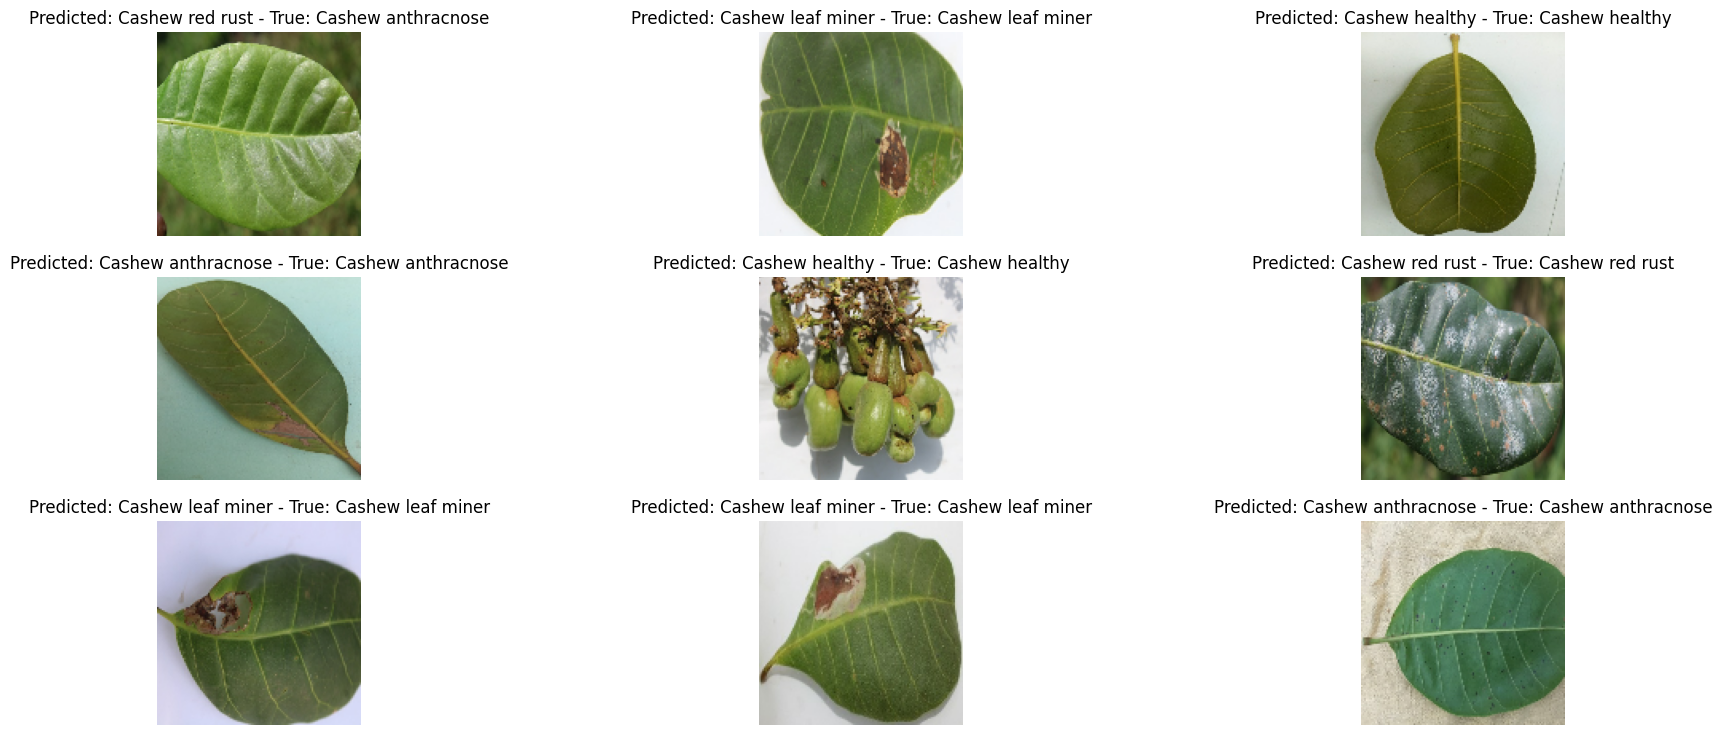

In [90]:
plt.figure(figsize=(22, 9))
for image, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(
            f"Predicted: {CLASS_NAMES[y_pred[i]]} - True: {CLASS_NAMES[y_true[i]]}"
        )
        plt.axis("off")

In [91]:
model.save("/kaggle/working/resetnet.h5")

# Googlenet


In [92]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    AveragePooling2D,
    Dropout,
    Flatten,
    Dense,
)
from tensorflow.keras.models import Model

In [93]:
# Constants
LEARNING_RATE = 0.0001
EPOCHS = 10

In [94]:
def inception_module(x, filters):
    """Function to create an Inception module."""
    conv1x1 = Conv2D(filters[0], (1, 1), padding="same", activation="relu")(x)

    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding="same", activation="relu")(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding="same", activation="relu")(
        conv3x3_reduce
    )

    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding="same", activation="relu")(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding="same", activation="relu")(
        conv5x5_reduce
    )

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding="same")(x)
    pool_proj = Conv2D(filters[5], (1, 1), padding="same", activation="relu")(maxpool)

    output = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=-1)
    return output


# Define GoogLeNet architecture
def googlenet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (5, 5), padding="same", strides=(2, 2), activation="relu")(inputs)
    x = MaxPooling2D((3, 3), padding="same", strides=(2, 2))(x)

    x = Conv2D(64, (1, 1), padding="same", activation="relu")(x)
    x = Conv2D(192, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D((3, 3), padding="same", strides=(2, 2))(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), padding="same", strides=(2, 2))(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = MaxPooling2D((3, 3), padding="same", strides=(2, 2))(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    # Adjust pooling size for the smaller input
    x = AveragePooling2D((4, 4))(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


# Create GoogLeNet model
input_shape = (128, 128, 3)  # Define your input image shape
num_classes = len(class_names)  # Number of output classes
model = googlenet(input_shape, num_classes)

In [95]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [96]:
# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           4864      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           4160      ['max_pooling2d[0][0]'] 

In [97]:
# Train the model
history = model.fit(train_ds, epochs=50, validation_data=validation_ds)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-05-14 10:25:25.068782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 42s 45ms/step - loss: 2.5413 - accuracy: 0.2157 - val_loss: 2.1301 - val_accuracy: 0.3044
Epoch 2/50
469/469 [==============================] - 19s 40ms/step - loss: 1.8836 - accuracy: 0.3836 - val_loss: 1.7540 - val_accuracy: 0.4100
Epoch 3/50
469/469 [==============================] - 18s 39ms/step - loss: 1.5874 - accuracy: 0.4711 - val_loss: 1.4968 - val_accuracy: 0.5112
Epoch 4/50
469/469 [==============================] - 18s 39ms/step - loss: 1.3619 - accuracy: 0.5373 - val_loss: 1.4116 - val_accuracy: 0.5468
Epoch 5/50
469/469 [==============================] - 18s 39ms/step - loss: 1.2202 - accuracy: 0.5829 - val_loss: 1.1479 - val_accuracy: 0.6172
Epoch 6/50
469/469 [==============================] - 18s 39ms/step - loss: 1.0741 - accuracy: 0.6290 - val_loss: 1.1357 - val_accuracy: 0.6196
Epoch 7/50
469/469 [==============================] - 18s 39ms/step - loss: 0.9786 - accuracy: 0.6605 - val_loss: 0.9717 - val_accuracy: 0.6730
Epo

In [98]:
# Assuming 'test_ds' is your test dataset
test_accuracy_googlenet = model.evaluate(test_ds, return_dict=True)["accuracy"]
print("Test Accuracy:", test_accuracy_googlenet)

160/160 [==============================] - 2s 13ms/step - loss: 1.2761 - accuracy: 0.7359
Test Accuracy: 0.7359374761581421


In [99]:
# Assuming 'test_ds' is your test dataset
test_loss_googlenet = model.evaluate(test_ds, return_dict=True)["loss"]
print("Test Loss:", test_loss_googlenet)

160/160 [==============================] - 2s 13ms/step - loss: 1.2761 - accuracy: 0.7359
Test Loss: 1.2760765552520752


Text(0.5, 0, 'Epoch')

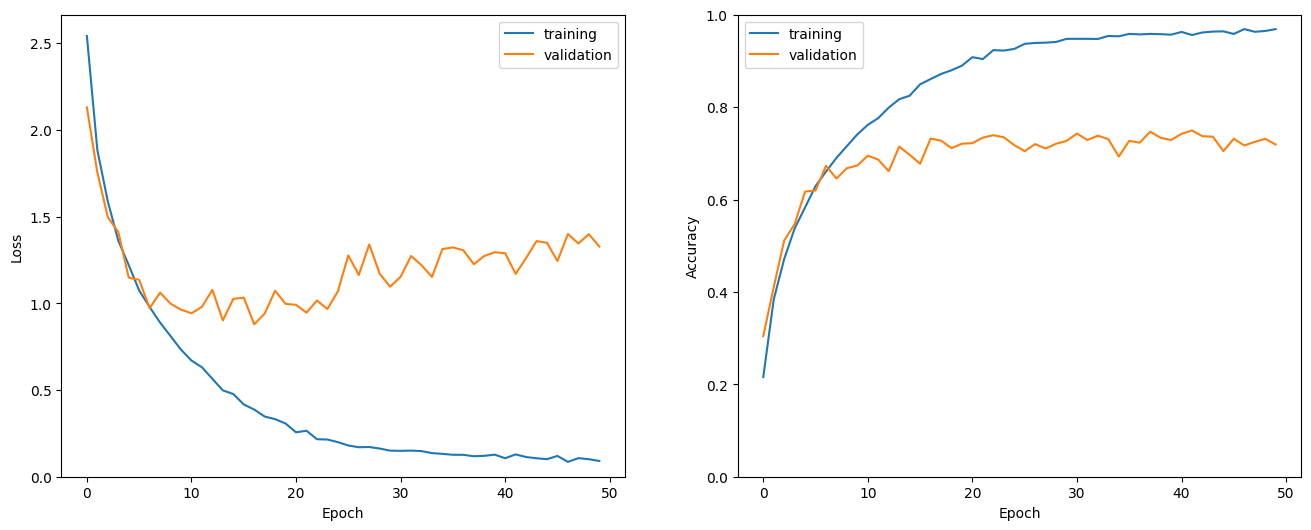

In [100]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["training", "validation"])
plt.ylim([0, max(plt.ylim())])
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics["accuracy"], metrics["val_accuracy"])
plt.legend(["training", "validation"])
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

In [101]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

160/160 [==============================] - 2s 11ms/step


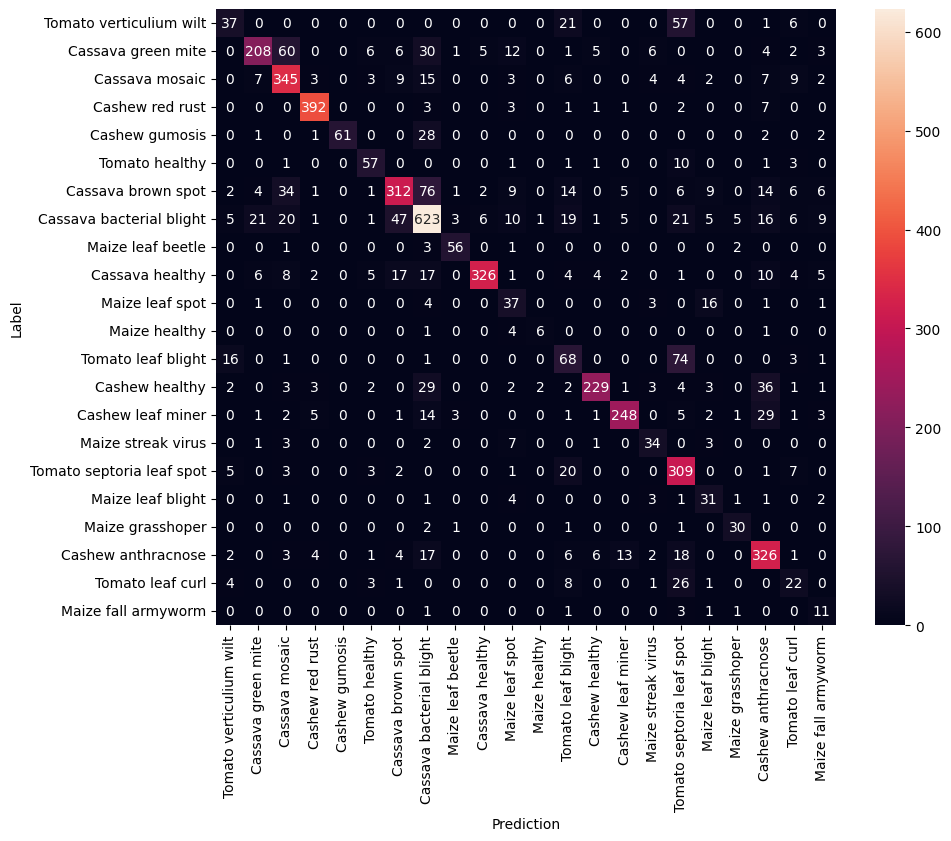

In [102]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

In [103]:
# Calculate precision, recall, and F1-score
precision = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
recall = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")
    print()

Class: Tomato verticulium wilt
  Precision: 0.5068
  Recall: 0.3033
  F1-score: 0.3795

Class: Cassava green mite
  Precision: 0.8320
  Recall: 0.5960
  F1-score: 0.6945

Class: Cassava mosaic
  Precision: 0.7113
  Recall: 0.8234
  F1-score: 0.7633

Class: Cashew red rust
  Precision: 0.9515
  Recall: 0.9561
  F1-score: 0.9538

Class: Cashew gumosis
  Precision: 1.0000
  Recall: 0.6421
  F1-score: 0.7821

Class: Tomato healthy
  Precision: 0.6951
  Recall: 0.7600
  F1-score: 0.7261

Class: Cassava brown spot
  Precision: 0.7820
  Recall: 0.6215
  F1-score: 0.6926

Class: Cassava bacterial blight
  Precision: 0.7186
  Recall: 0.7552
  F1-score: 0.7364

Class: Maize leaf beetle
  Precision: 0.8615
  Recall: 0.8889
  F1-score: 0.8750

Class: Cassava healthy
  Precision: 0.9617
  Recall: 0.7913
  F1-score: 0.8682

Class: Maize leaf spot
  Precision: 0.3895
  Recall: 0.5873
  F1-score: 0.4684

Class: Maize healthy
  Precision: 0.6667
  Recall: 0.5000
  F1-score: 0.5714

Class: Tomato leaf b

In [104]:
# Calculate overall metrics
macro_avg_precision = np.mean(precision)
macro_avg_recall = np.mean(recall)
macro_avg_f1_score = np.mean(f1_score)

print("Overall Metrics:")
print(f"  Macro-average Precision: {macro_avg_precision:.4f}")
print(f"  Macro-average Recall: {macro_avg_recall:.4f}")
print(f"  Macro-average F1-score: {macro_avg_f1_score:.4f}")

Overall Metrics:
  Macro-average Precision: 0.6774
  Macro-average Recall: 0.6808
  Macro-average F1-score: 0.6649


In [105]:
print(y_pred)

[13 14 13 ... 16  5  0]


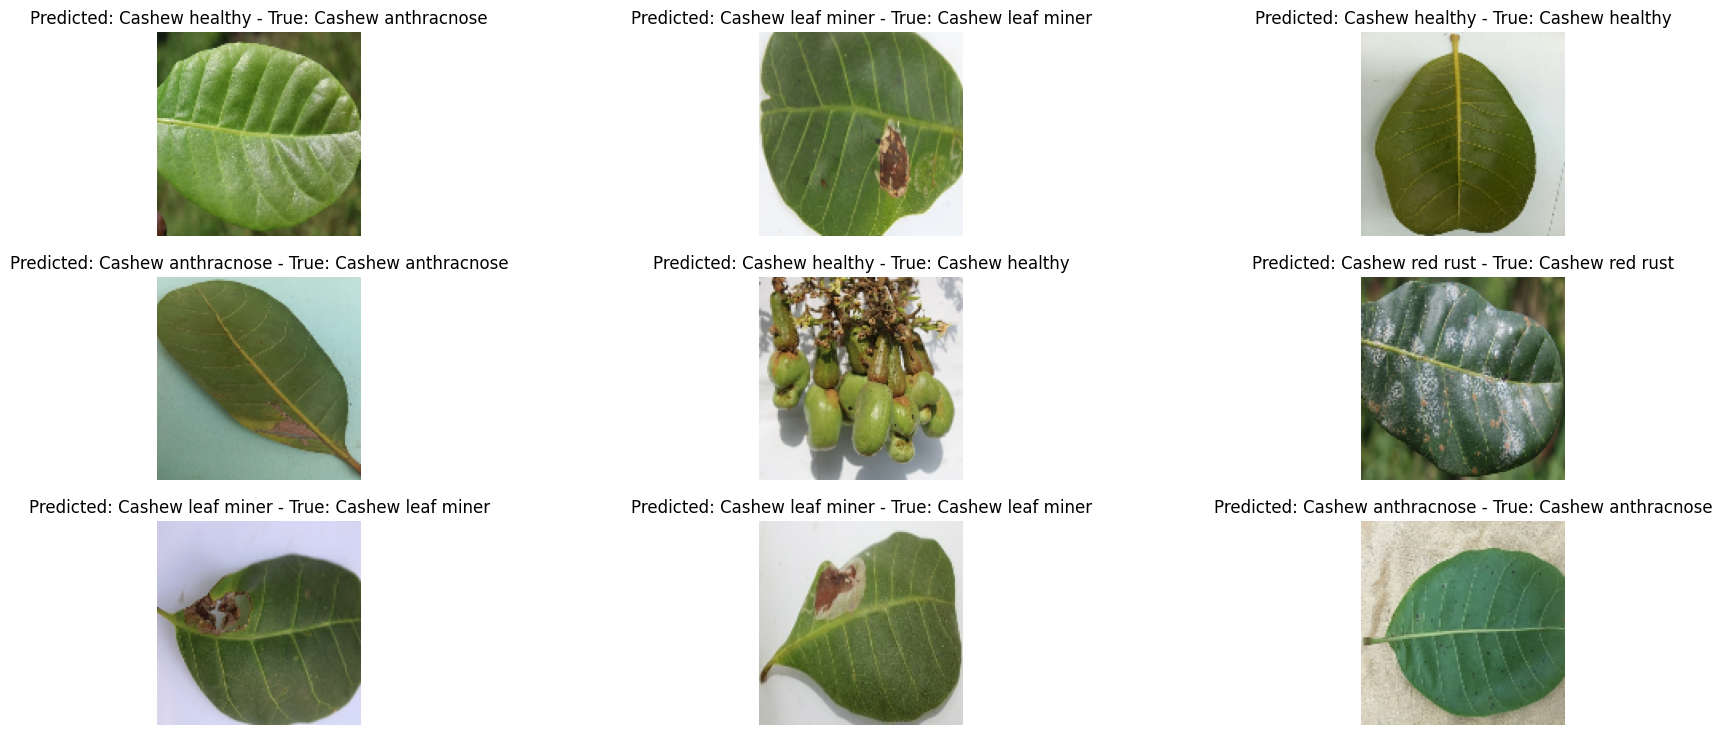

In [110]:
plt.figure(figsize=(22, 9))
for image, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(
            f"Predicted: {CLASS_NAMES[y_pred[i]]} - True: {CLASS_NAMES[y_true[i]]}"
        )
        plt.axis("off")

In [107]:
model.save("/kaggle/working/googlenet.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Comparison


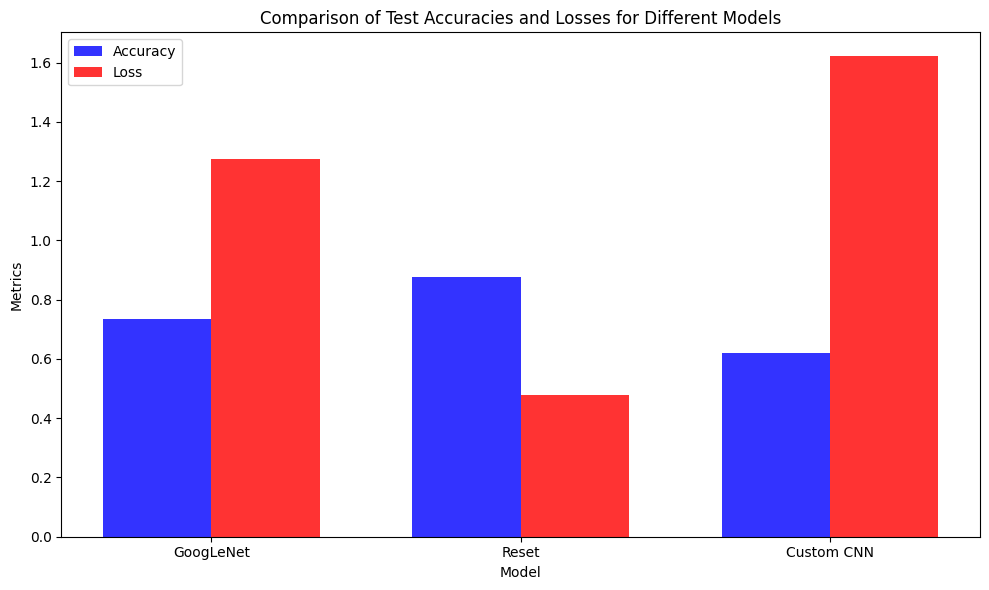

In [108]:
# Define model names and corresponding test accuracies and losses
model_names = ["GoogLeNet", "Reset", "Custom CNN"]
test_accuracies = [test_accuracy_googlenet, test_accuracy_resnet, test_accuracy_custom]
test_losses = [
    test_loss_googlenet,
    test_loss_resnet,
    test_loss_custom,
]  # Assuming you have test losses

# Plotting test accuracies and losses
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting test accuracies as bars
bar_width = 0.35
opacity = 0.8
index = range(len(model_names))

rects1 = ax.bar(
    index, test_accuracies, bar_width, alpha=opacity, color="b", label="Accuracy"
)
rects2 = ax.bar(
    [i + bar_width for i in index],
    test_losses,
    bar_width,
    alpha=opacity,
    color="r",
    label="Loss",
)

# Adding labels, title, and legend
ax.set_xlabel("Model")
ax.set_ylabel("Metrics")
ax.set_title("Comparison of Test Accuracies and Losses for Different Models")
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(model_names)
ax.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

In [109]:
# Determine the best model based on accuracy
best_accuracy_idx = test_accuracies.index(max(test_accuracies))
best_model_accuracy = model_names[best_accuracy_idx]
best_accuracy = test_accuracies[best_accuracy_idx]

# Determine the best model based on loss
best_loss_idx = test_losses.index(min(test_losses))
best_model_loss = model_names[best_loss_idx]
best_loss = test_losses[best_loss_idx]

print(
    f"Best Model (Highest Test Accuracy): {best_model_accuracy} ({best_accuracy:.4f})"
)
print(f"Best Model (Lowest Test Loss): {best_model_loss} ({best_loss:.4f})")

Best Model (Highest Test Accuracy): Reset (0.8771)
Best Model (Lowest Test Loss): Reset (0.4779)
